# Entropy (validation)

Date : 22/06/2018  <br>
Author : SL   <br>
Code : https://github.com/bosscha/alma  <br>

## Scope

To validate (or not) we perform simulations with C43-X on a trial of sources and we compare the results with N random array configurations taken from the underlying pads. <br>
We show the entropy analysis in this nb. <br>
<br>
Simulations produced by *runValidateEntropy.py*


In [137]:
import os, shutil , glob , pickle
import matplotlib.pyplot as pl
from pylab import rcParams
import numpy as np
import math
from sklearn.metrics import mutual_info_score
from numpy import unique
from scipy.stats import entropy as scipy_entropy


from astropy.io import fits
from astropy.stats import histogram
from astropy.wcs import WCS


%matplotlib inline

RAD2ARCSEC = 180. / math.pi

In [138]:
def MutualInformation(im1, im2, binsize = 20):
    "Compute the mutual information between im1 and im2"
    
    
    hgram, x_edges, y_edges = np.histogram2d(im1.ravel(), im2.ravel(), bins = binsize)
    
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    mi = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))
    
    return(mi)

In [139]:
def isFitsN(n):
    "Check if fits n is in the products directory. rootname s the string basis of the fits"
    
    fitsname = "simRan.compskymodel.flat.regrid.conv.fits.%d"%(n)
    
    if os.path.exists(fitsname):
        return(True)
    else :
        return(False)    

In [140]:
def compute_mistats(arrStdName, binsize = 20, resClipping = False, Tol = 0.1):
    "Compute the MI for the trial and arrStdName"
    
    
    miTarget = []
    miRandom = []
    resRandom = []
    
    index = 0
    while(isFitsN(index)):
        sim1   = "%s.image.fits.%d"%(arrStdName,index)
        model1 = "%s.compskymodel.flat.regrid.conv.fits.%d"%(arrStdName,index)   
        with fits.open(model1) as m1:
            in1 = m1[0].data
            bmin1 = m1[0].header['bmin'] * 3600.
            bmaj1 = m1[0].header['bmaj'] * 3600.
            bres1 = math.sqrt(bmin1 * bmaj1)
            
        with fits.open(sim1) as s1:
            out1 = s1[0].data
        mi1  = MutualInformation(in1 , out1 , binsize)  
 
        
        sim2   = "simRan.image.fits.%d"%(index)
        model2 = "simRan.compskymodel.flat.regrid.conv.fits.%d"%(index)    
        with fits.open(model2) as m2:
            in2 = m2[0].data
            bmin2 = m2[0].header['bmin'] * 3600.
            bmaj2 = m2[0].header['bmaj'] * 3600.
            bres2 = math.sqrt(bmin2 * bmaj2)
        
        with fits.open(sim2) as s2:
            out2 = s2[0].data
        mi2  = MutualInformation(in2 , out2, binsize)
        
        diffRes = abs(bres2-bres1) / bres1
        miTarget.append(mi1)
        if resClipping and diffRes < Tol:
            miRandom.append(mi2)
            resRandom.append(bres2)
            
        if not resClipping:
            miRandom.append(mi2)
            resRandom.append(bres2)
        
        index += 1
        
        
    print("## %d images found"%(len(miRandom)))
    return(miTarget, miRandom, resRandom, bres1)    

In [141]:
def pickle_result(filename, data):  
    with open(filename, 'w') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [142]:
def read_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        
    return(data)

### Analysis ...

The clip boolean allows to select the random array in a resolution range close to the target resolution (within the tolerance Tol)

In [143]:
# wdir = "/home/stephane/Science/ALMA/ArrayConfig/imaging/fullcombination/simEntropy/products"
wdir = "/home/stephane/Science/ALMA/ArrayConfig/imaging/entropy/simentropy/products"
# wdir = "/home/stephane/Science/ALMA/ArrayConfig/imaging/fullcombination/simulationEntropy/products"
os.chdir(wdir)

## 59 images found
## no clipping

## Target MI:
## Mean: 0.014547
## Std: 0.006519
## RES: 1.760765

## Random MI:
## Mean: 0.020946
## Std: 0.012745
## RES(mean): 1.792083


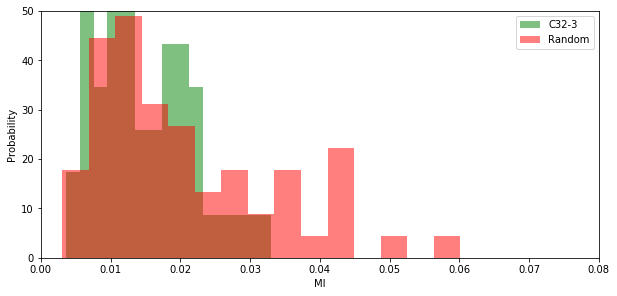

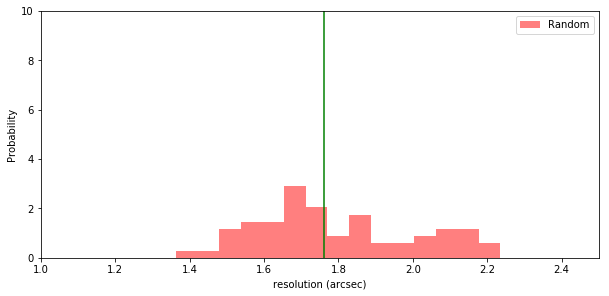

In [144]:
clip = False
tolerance = 0.1
bin = 10
miTarget , miRandom, resRandom, resTarget = compute_mistats("alma.cycle2.3", resClipping = clip, Tol = tolerance, binsize = bin)

if  clip :
    print("## Clipping in resolution to %3.1f%%"%(tolerance*100.))
else:
    print("## no clipping")
    
tarnp = np.array(miTarget)
print("\n## Target MI:")
print("## Mean: %f"%(tarnp.mean()))
print("## Std: %f"%(tarnp.std()))
print("## RES: %f"%(resTarget))
print()

rannp  = np.array(miRandom)
ranres = np.array(resRandom)

print("## Random MI:")
print("## Mean: %f"%(rannp.mean()))
print("## Std: %f"%(rannp.std()))
print("## RES(mean): %f"%(ranres.mean()))

rcParams['figure.figsize'] = 10, 10.0

pl.subplot(2, 1, 1)
n1, bins1, patches1 = pl.hist(miTarget, 15, density=True, facecolor='g', alpha=0.5, label = "C32-3")
n2, bins2, patches2 = pl.hist(miRandom, 15, density=True, facecolor='r', alpha=0.5, label = "Random")
pl.xlabel('MI')
pl.ylabel('Probability')
pl.axis([0., 0.08, 0, 50.0])
pl.legend(loc = "upper right")
pl.show()

pl.subplot(2, 1, 2)
n2, bins2, patches2 = pl.hist(resRandom, 15, density=True, facecolor='r', alpha=0.5, label = "Random")
pl.xlabel('resolution (arcsec)')
pl.ylabel('Probability')
pl.plot([resTarget,resTarget],[0.,1000], "g-")
pl.axis([1.0, 2.5, 0, 10.0])
pl.legend(loc = "upper right")
pl.show()